# Image Classification Batch Inference with PyTorch

In this example, we will introduce how to use the Ray Data for large-scale batch inference with multiple GPU workers.

Source: https://docs.ray.io/en/latest/data/examples/pytorch_resnet_batch_prediction.html

## Reading the Dataset from S3

In [18]:
import ray

if ray.is_initialized():
    ray.shutdown()
ray.init()

s3_uri = "s3://anonymous@air-example-data-2/imagenette2/train/"

ds = ray.data.read_images(s3_uri, mode="RGB")
ds

2023-09-06 12:20:02,215	INFO worker.py:1612 -- Started a local Ray instance. View the dashboard at 127.0.0.1:8265 


Dataset(
   num_blocks=200,
   num_rows=9469,
   schema={image: numpy.ndarray(ndim=3, dtype=uint8)}
)

In [19]:
ds.schema()

Column  Type
------  ----
image   numpy.ndarray(ndim=3, dtype=uint8)

##  Inference on a single batch

In [20]:
single_batch = ds.take_batch(10)

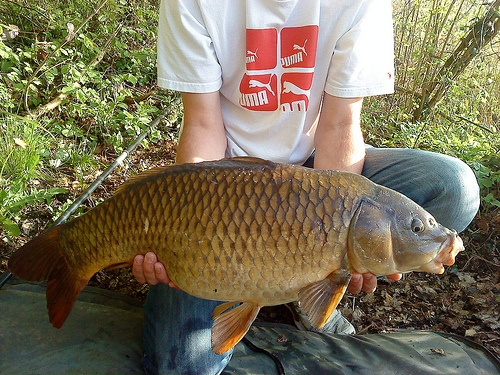

In [21]:
from PIL import Image

img = Image.fromarray(single_batch["image"][5])
img

Now, let’s download a pre-trained PyTorch Resnet model and get the required preprocessing transforms to preprocess the images prior to prediction.

In [22]:
import torch
from torchvision.models import ResNet152_Weights
from torchvision import transforms
from torchvision import models

weights = ResNet152_Weights.IMAGENET1K_V1

# Load the pretrained resnet model and move to GPU if one is available.

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.resnet152(weights=weights).to(device)
model.eval()

imagenet_transforms = weights.transforms
transform = transforms.Compose([transforms.ToTensor(), imagenet_transforms()])

In [23]:
transformed_batch = [transform(image) for image in single_batch["image"]]
with torch.inference_mode():
    prediction_results = model(torch.stack(transformed_batch).to(device))
    classes = prediction_results.argmax(dim=1).cpu()

del model  # Free up GPU memory

labels = [weights.meta["categories"][i] for i in classes]
labels

/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


['tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'tench',
 'bittern',
 'tench']

## Scaling up to the full Dataset with Ray Data

### Preprocessing

In [24]:
import numpy as np
from typing import Any, Dict

def preprocess_image(row: Dict[str, np.ndarray]):
    return {
        "original_image": row["image"],
        "transformed_image": transform(row["image"]),
    }
    
transformed_ds = ds.map(preprocess_image)

### Model inference

In [25]:
from typing import Dict
import numpy as np
import torch


class ResnetModel:
    def __init__(self):
        self.weights = ResNet152_Weights.IMAGENET1K_V1
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.model = models.resnet152(weights=self.weights).to(self.device)
        self.model.eval()

    def __call__(self, batch: Dict[str, np.ndarray]):
        # Convert the numpy array of images into a PyTorch tensor.
        # Move the tensor batch to GPU if available.
        torch_batch = torch.from_numpy(batch["transformed_image"]).to(self.device)
        with torch.inference_mode():
            prediction = self.model(torch_batch)
            predicted_classes = prediction.argmax(dim=1).detach().cpu()
            predicted_labels = [
                self.weights.meta["categories"][i] for i in predicted_classes
            ]
            return {
                "predicted_label": predicted_labels,
                "original_image": batch["original_image"],
            }

In [26]:
predictions = transformed_ds.map_batches(
    ResnetModel,
    compute=ray.data.ActorPoolStrategy(
        size=1
    ),  # Use 1 GPUs. Change this number based on the number of GPUs in your cluster.
    num_gpus=1,  # Specify 1 GPU per model replica.
    batch_size=240,  # Use the largest batch size that can fit on our GPUs
)

In [27]:
prediction_batch = predictions.take_batch(5)

2023-09-06 12:21:07,322	INFO streaming_executor.py:92 -- Executing DAG InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->Map(preprocess_image)] -> ActorPoolMapOperator[MapBatches(ResnetModel)]
2023-09-06 12:21:07,323	INFO streaming_executor.py:93 -- Execution config: ExecutionOptions(resource_limits=ExecutionResources(cpu=None, gpu=None, object_store_memory=None), locality_with_output=False, preserve_order=False, actor_locality_enabled=True, verbose_progress=False)
2023-09-06 12:21:07,323	INFO streaming_executor.py:95 -- Tip: For detailed progress reporting, run `ray.data.DataContext.get_current().execution_options.verbose_progress = True`
2023-09-06 12:21:07,436	INFO actor_pool_map_operator.py:117 -- MapBatches(ResnetModel): Waiting for 1 pool actors to start...


Running 0:   0%|          | 0/200 [00:00<?, ?it/s]

(ReadImage->Map(preprocess_image) pid=13127) Task failed with retryable exception: TaskID(9b825cf87717b347ffffffffffffffffffffffff01000000).
(ReadImage->Map(preprocess_image) pid=13127) Traceback (most recent call last):
(ReadImage->Map(preprocess_image) pid=13127)   File "python/ray/_raylet.pyx", line 1191, in ray._raylet.execute_dynamic_generator_and_store_task_outputs
(ReadImage->Map(preprocess_image) pid=13127)   File "python/ray/_raylet.pyx", line 3684, in ray._raylet.CoreWorker.store_task_outputs
(ReadImage->Map(preprocess_image) pid=13127)   File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/_internal/execution/operators/map_operator.py", line 415, in _map_task
(ReadImage->Map(preprocess_image) pid=13127)     for b_out in fn(iter(blocks), ctx):
(ReadImage->Map(preprocess_image) pid=13127)   File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/_internal/planner/plan_udf_map_op.py", line 76, in do_map
(ReadImage->Map(preprocess_image) pid=13127)  

RayTaskError(OSError): [36mray::ReadImage->Map(preprocess_image)()[39m (pid=13130, ip=192.168.33.188)
  File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/_internal/execution/operators/map_operator.py", line 415, in _map_task
    for b_out in fn(iter(blocks), ctx):
  File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/_internal/planner/plan_udf_map_op.py", line 76, in do_map
    yield from transform_fn(blocks, ctx, *fn_args, **fn_kwargs)
  File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/_internal/planner/map_rows.py", line 23, in fn
    for block in blocks:
  File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/_internal/planner/plan_read_op.py", line 67, in do_read
    yield from read_task()
  File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/datasource/datasource.py", line 214, in __call__
    for block in result:
  File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/datasource/file_based_datasource.py", line 477, in read_files
    with open_input_source(fs, read_path, **open_stream_args) as f:
  File "/home/mpp/.conda/envs/ray/lib/python3.9/site-packages/ray/data/datasource/file_based_datasource.py", line 226, in _open_input_source
    return filesystem.open_input_stream(path, buffer_size=buffer_size, **open_args)
  File "pyarrow/_fs.pyx", line 812, in pyarrow._fs.FileSystem.open_input_stream
  File "pyarrow/error.pxi", line 144, in pyarrow.lib.pyarrow_internal_check_status
  File "pyarrow/error.pxi", line 115, in pyarrow.lib.check_status
OSError: When reading information for key 'imagenette2/train/n01440764/n01440764_10847.JPEG' in bucket 'air-example-data-2': AWS Error NETWORK_CONNECTION during HeadObject operation: curlCode: 28, Timeout was reached

In [28]:
ray.shutdown()